### dependencies

In [18]:
import pickle
import pandas as pd
import numpy as np
import time
import re
import os
from tqdm import tqdm as progress_bar

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from bornrule import BornClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import explanation_BORN
from matplotlib.gridspec import GridSpec

### functions

In [29]:
def prediction_function(classifier_dict, classifier_, histogram_train, y_train, histogram_test, y_test):
    classifier = classifier_dict[classifier_]
    start = time.time()
    classifier.fit(histogram_train, y_train)
    y_pred = classifier.predict(histogram_test)
    end = time.time()-start
    results = {'y_obs': y_test, 'y_pred': y_pred}
    return results, end

def load_and_classify(classifier_dict, classifier_, file_path):
    # Estrazione dei parametri dal nome del file
    file_name = os.path.basename(file_path)
    match = re.match(r'(\w+)_(\w+)_(\w+)_(\w+)\.pkl', file_name)
    if match:
        dataset = match.group(1)
        extractor_name = match.group(2)
        distance_metric = match.group(3)
        k = int(match.group(4))
    else:
        raise ValueError("Nome del file non conforme al formato previsto.")
    
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    histogram_train = np.array(data['histograms_train'])
    y_train = np.array(data['y_train'])
    histogram_test = np.array(data['histograms_test'])
    y_test = np.array(data['y_test'])

    results, comp_time = prediction_function(classifier_dict, classifier_, histogram_train, y_train, histogram_test, y_test)
    f1 = f1_score(results['y_obs'], results['y_pred'], average='macro')
    
    tuning_results = []
    tuning_results.append({
        'Params': {'classifier': classifier_, 'dataset':dataset, 'extractor': extractor_name, 'distance_metric': distance_metric, 'k': k},
        'F1_Score': f1 * 100,
        'Comp_time': comp_time
    })
    
    return tuning_results

def results_to_dataframe(results_dict):
    records = []
    for sublist in results_dict:
        for result in sublist:
            params = result['Params']
            dataset = params.get('dataset')
            classifier = params.get('classifier')
            extractor = params.get('extractor')
            distance_metric = params.get('distance_metric')
            k = params.get('k')
            f1_score = result.get('F1_Score')
            computational_time = result.get('Comp_time')
            
            records.append((classifier, dataset, extractor, distance_metric, k, round(f1_score, 3), round(computational_time, 3)))

    df = pd.DataFrame(records, columns=['Dataset', 'Classifier', 'Extractor', 'Distance_Metric', 'K', 'F1_Score(%)', 'Computational_time(s)'])
    df = df.sort_values(by='F1_Score(%)', ascending=False)
    
    return df

In [30]:
def extract_train_and_test(file_path):
    # Estrazione dei parametri dal nome del file
    file_name = os.path.basename(file_path)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    histogram_train = np.array(data['histograms_train'])
    y_train = np.array(data['y_train'])
    histogram_test = np.array(data['histograms_test'])
    y_test = np.array(data['y_test'])
    
    return histogram_train, histogram_test, y_train, y_test

### Multiclass

In [33]:
# file_path = 'Histograms_repository'
# file_names = [f"{file_path}/{f}" for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]

classifiers = {
    "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
    "BORN(1,0,1)": BornClassifier(1,0,1),
    "BORN(0.5,1,0)": BornClassifier(0.5,1,0),
    "BORN(1,0,0)": BornClassifier(1,0,0)
    }


#SELECT Histograms 

# k_list = [100, 1000, 2500]
# dataset = 'CIFAR10'

# born_files = []
# for k in k_list:
    
#     for i in range(len(file_names)):
#         Hist, rc, extr, dist, vv = file_names[i].split("_")
#         if extr == 'SIFT' and rc[11:] == dataset and dist == 'euclidean'and vv[:-4] == str(k): 
#             born_files.append(file_names[i])

#     born_files

# born_files

#or 

born_files = ['cifar_resnet_100', 'cifar_detr_res_100', 'cifar_detr_pixel_100']


default_conf = born_files[0]
xt, xp, yt, yp = extract_train_and_test(default_conf)

In [61]:
def get_explanation_results(classifier_, xt=xt, yt=yt, xp=xp, yp=yp, classifiers=classifiers):

    classifier = classifiers[classifier_]
    classifier.fit(xt, yt)

    Global_explanation = classifier.explain()
    prediction = classifier.predict(xp)

    conf_matrix = confusion_matrix(yp, prediction)
    f1 = f1_score(yp, prediction, average = 'weighted')

    return {'Born configuration': classifier_,
            'global_explanation': Global_explanation,
            'confusion_matrix':  conf_matrix, 
            'f1_score': f1}

explanations_result = [get_explanation_results(classifier) for classifier in classifiers]

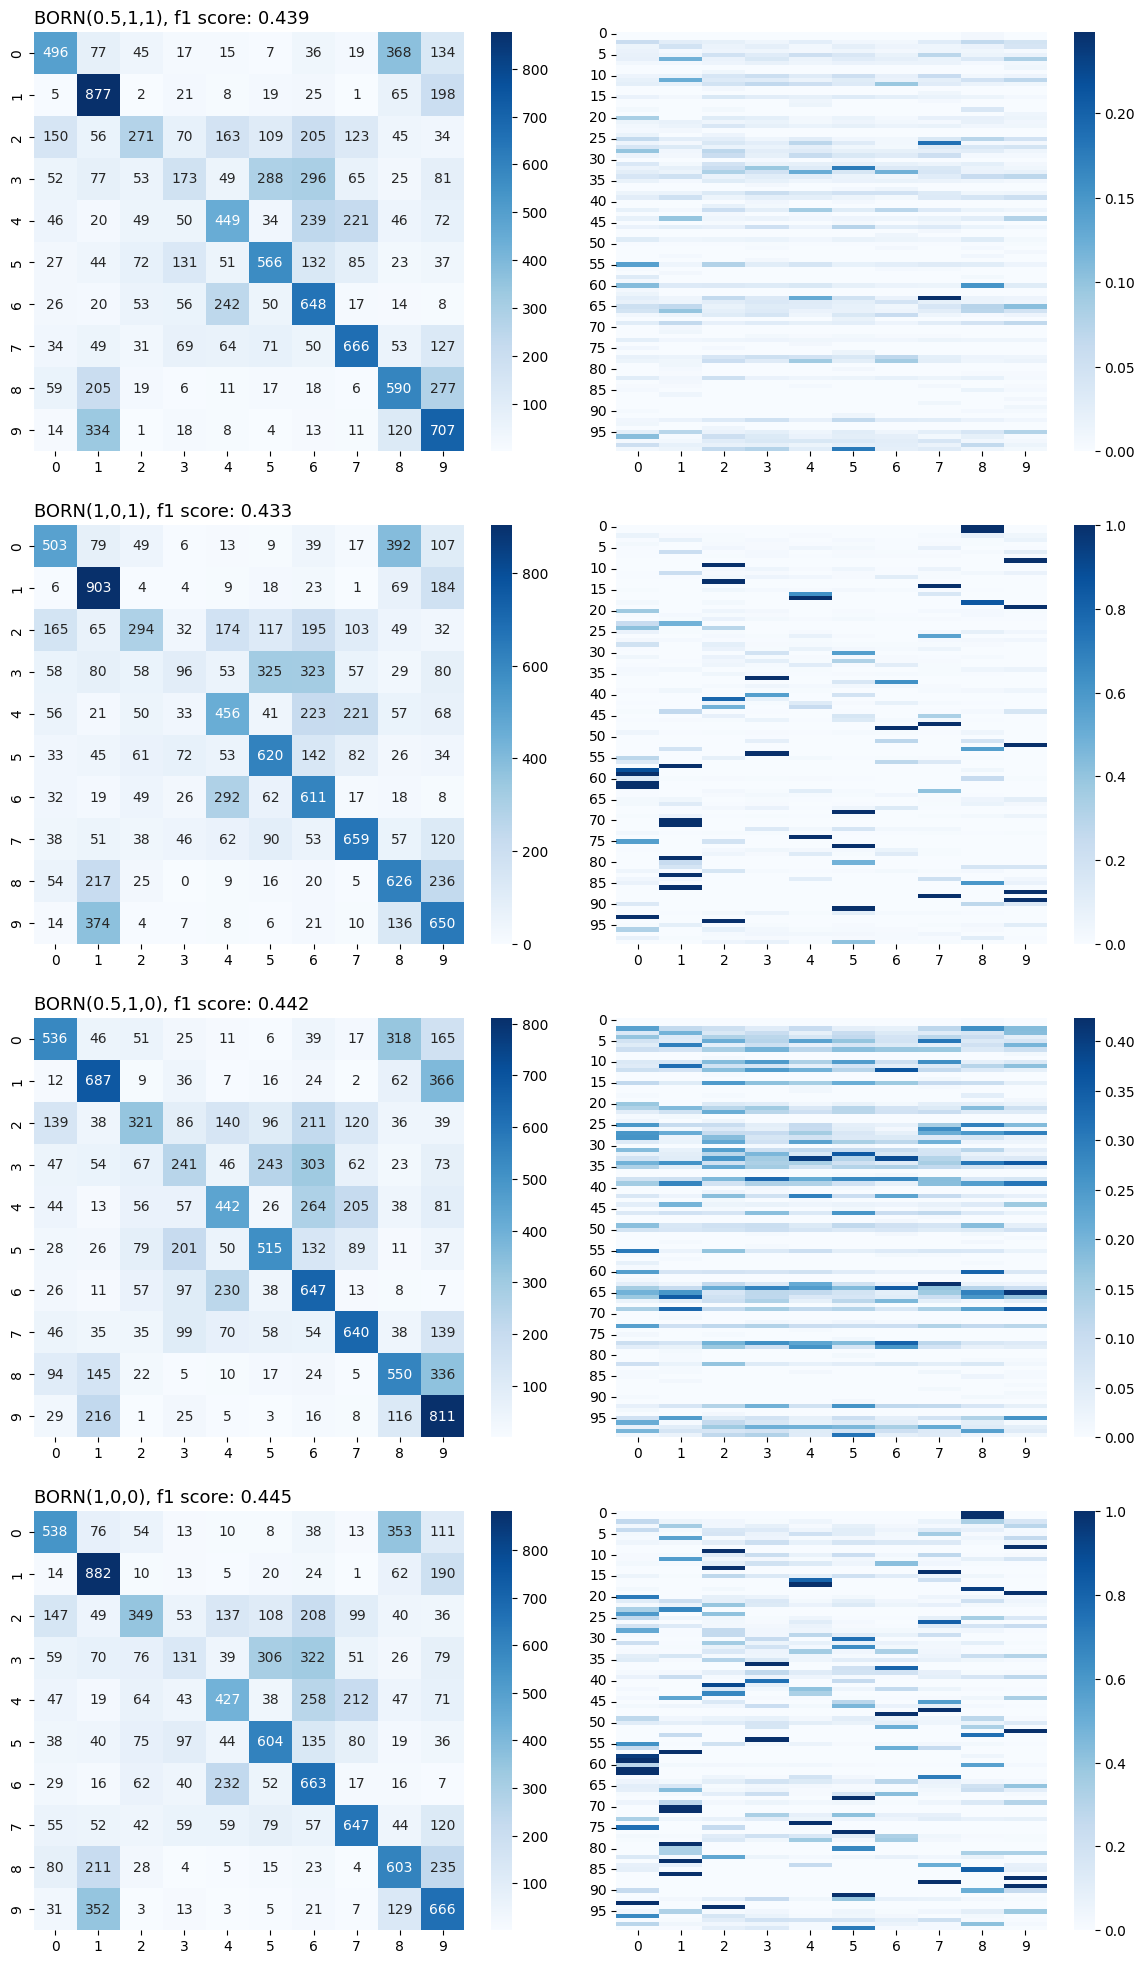

In [25]:
## CONFUSION MATRIX and HEATMAP CIFAR IMAGENET

fig, axes = plt.subplots(nrows=len(classifiers), ncols=2, figsize=(12, 5 * len(classifiers)))

for i, (result, classifier_name) in enumerate(zip(explanations_result, classifiers.keys())):
    #cm = 'Blues' if classifier_name == 'BORN(0.5,1,1)' or classifier_name == 'BORN(1,0,1)' else 'Reds'
    
    #confusion matrix
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=axes[i, 0], cmap='Blues')
    axes[i, 0].set_title(f'{classifier_name}, f1 score: {round(result["f1_score"], 3)}', loc='left', fontsize = 13)
    
    #global explaination
    sns.heatmap(result['global_explanation'], ax=axes[i, 1], cmap='Blues')
    #axes[i, 1].set_title('Global Explanation')

plt.tight_layout(pad=2.0)
plt.show()

### Decompose W(G),E,P

In [124]:
import scipy.sparse
import numpy 
def explain(X=None, sample_weight=None):

    if X is None:
        return _weights()

    X = _normalize(X, axis=1)
    X = _power(X, 0.5)

    return _multiply(_weights(), _sum(X, axis=0).T)


def _dense():
    return  numpy

def _sparse():
    return scipy.sparse


def _weights(Pjk, a, b):
    print(a,b)
    P_jk = Pjk
    if b != 0:
        P_jk = _multiply(P_jk, _power(_sum(Pjk, axis=0), -b))
    if b != 1:
        P_jk = _multiply(P_jk, _power(_sum(Pjk, axis=1), b-1))

    W_jk = _power(P_jk, a)
    P_jk = _normalize(P_jk, axis=1)
    H_j = 1 + _sum(_multiply(P_jk, _log(P_jk)), axis=1) / _dense().log(P_jk.shape[1])
    W_f = _multiply(W_jk, _power(H_j, 1))

    return W_f, H_j, W_jk

def _sum(x, axis):
    if _sparse().issparse(x):
        return x.sum(axis=axis)

    return _dense().asarray(x).sum(axis=axis, keepdims=True)

def _multiply(x, y):
    if _sparse().issparse(x):
        return x.multiply(y).tocsr()

    if _sparse().issparse(y):
        return y.multiply(x).tocsr()

    return _dense().multiply(x, y)

def _power(x, p):
    x = x.copy()

    if _sparse().issparse(x):
        x.data = _dense().power(x.data, p)

    else:
        nz = _dense().nonzero(x)
        x[nz] = _dense().power(x[nz], p)

    return x

def _log(x):
    x = x.copy()

    if _sparse().issparse(x):
        x.data = _dense().log(x.data)

    else:
        nz = _dense().nonzero(x)
        x[nz] = _dense().log(x[nz])

    return x

def _normalize(x, axis, p=1.):
    s = _sum(x, axis)
    n = _power(s, -p)

    return _multiply(x, n)

In [27]:
##SELECT file to import

# file_path = 'Histograms_repository'
# file_names = [f"{file_path}/{f}" for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]

# classifiers = {
#     "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
#     "BORN(1,0,1)": BornClassifier(1,0,1)
#     }


# file_names[0].split("_")

# k = 100
# dataset = 'IMAGENET'

# born_files = []
    
# for i in range(len(file_names)):
#     Hist, rc, extr, dist, vv = file_names[i].split("_")
#     if extr == 'SIFT' and rc[11:] == dataset and dist == 'euclidean'and vv[:-4] == str(k): 
#         born_files.append(file_names[i])


# born_files

# default_conf = born_files[0]
# xt, xp, yt, yp = extract_train_and_test(default_conf)

0.5 1


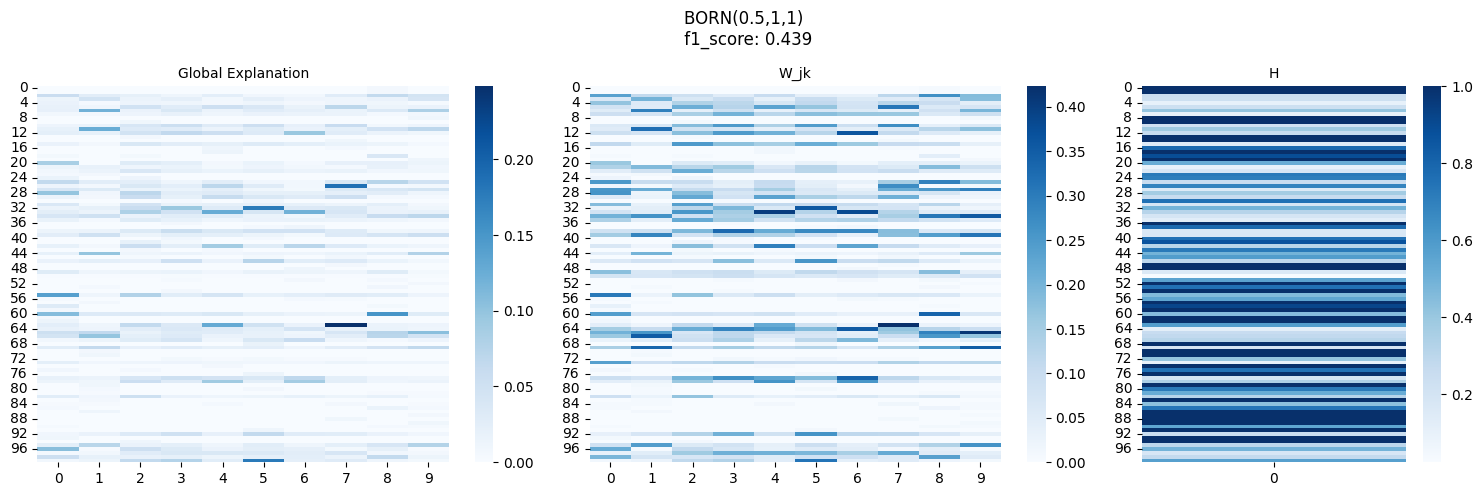

In [125]:
#classifier
classifier = classifiers['BORN(0.5,1,1)']
classifier.fit(xt, yt)
prediction = classifier.predict(xp)

conf_matrix = confusion_matrix(yp, prediction)
f1 = f1_score(yp, prediction, average = 'weighted')

Pjk = classifier.corpus_
#decompose
W, H, P= _weights(Pjk,0.5,1)

maxH, minH = round(np.max(H), 3), round(np.min(H), 3)

plt.figure(figsize=(15, 5))
gs = GridSpec(1, 8) 

plt.subplot(gs[0, 0:3])
sns.heatmap(W, cbar=True, annot_kws={"size": 7}, fmt=".1f", cmap='Blues')
plt.title("Global Explanation", fontsize=10)

plt.subplot(gs[0, 3:6])
sns.heatmap(P, cbar=True, annot_kws={"size": 7}, fmt=".0f", cmap='Blues')
plt.title("W_jk", fontsize=10)

plt.subplot(gs[0, 6:])
sns.heatmap(H, cbar=True, cmap='Blues')
plt.title(f"H", fontsize=10)

#plt.title("BORN(1,0,1)")
plt.suptitle(f'BORN(0.5,1,1) \n f1_score: {round(f1, 3)}', fontsize=12)
plt.tight_layout(pad=1.0)
plt.show()

### Feature influence - Entropy

In [16]:
file_path = 'Histograms_repository'
file_names = [f"{file_path}/{f}" for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]

k_list = [10, 100, 1000, 2500, 5000]
dataset = 'CIFAR10'

born_files = []
for k in k_list:
    
    for i in range(len(file_names)):
        Hist, rc, extr, dist, vv = file_names[i].split("_")
        if extr == 'SIFT' and rc[11:] == dataset and dist == 'euclidean'and vv[:-4] == str(k): 
            born_files.append(file_names[i])

    born_files

born_files

['Histograms_repository/CIFAR10_SIFT_euclidean_10.pkl',
 'Histograms_repository/CIFAR10_SIFT_euclidean_100.pkl',
 'Histograms_repository/CIFAR10_SIFT_euclidean_1000.pkl',
 'Histograms_repository/CIFAR10_SIFT_euclidean_2500.pkl',
 'Histograms_repository/CIFAR10_SIFT_euclidean_5000.pkl']

In [ ]:
import Born_Algorithm as BA

def get_entropy(xt,yt):
    Eclassifier = BA.BornClassifier()
    Eclassifier.fit(xt,yt)
    Eclassifier.explain()
    return Eclassifier.Entropy

In [ ]:
entropy_dict = {}
for file in born_files:
    print(file)
    xt, _, xp, _ = extract_train_and_test(file) #extract train test

    H = get_entropy(xt,xp) #get entropy

    sorted_indices = np.argsort(H[:, 0])[::-1] #sort the array
    sorted_H = H[sorted_indices]

    entropy_dict[f"K_{file.split('_')[4][:-4]}"] = sorted_H #store

    print(f"K_{file.split('_')[4][:-4]}")

Histograms_repository/CIFAR10_SIFT_euclidean_10.pkl
K_10
Histograms_repository/CIFAR10_SIFT_euclidean_100.pkl
K_100
Histograms_repository/CIFAR10_SIFT_euclidean_1000.pkl
K_1000
Histograms_repository/CIFAR10_SIFT_euclidean_2500.pkl
K_2500
Histograms_repository/CIFAR10_SIFT_euclidean_5000.pkl
K_5000


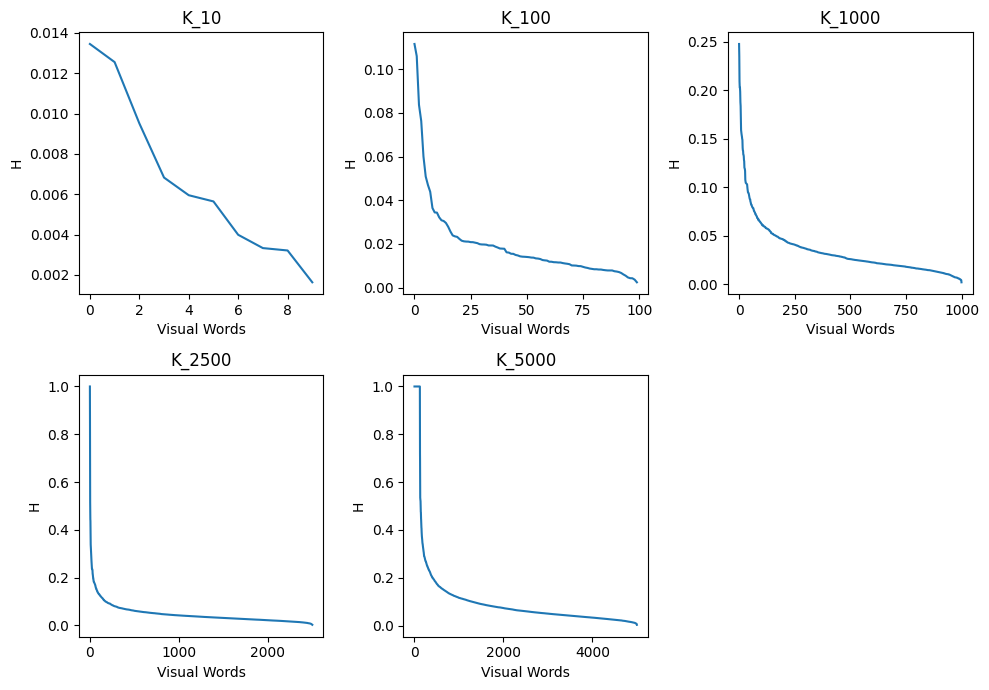

In [ ]:
def plot_grids(data):
    num_plots = len(data)
    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.flatten()
    
    for ax, (key, array) in zip(axes, data.items()):
        ax.plot(array)
         # Aggiungi una linea verticale rossa a x=10
        ax.set_title(key)
        ax.set_xlabel('Visual Words')
        ax.set_ylabel('H')

    # Nascondi gli assi vuoti
    for i in range(len(data), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Chiamata della funzione per visualizzare i plot
plot_grids(entropy_dict)

In [ ]:
from collections import Counter
max_indices = np.argmax(P, axis=1)

# Counting the frequency of each column index
counter_result = Counter(max_indices)
print(counter_result)

Counter({9: 20, 5: 20, 8: 15, 0: 14, 1: 7, 2: 6, 6: 6, 7: 6, 4: 4, 3: 2})


### Filter

In [ ]:
##SELECT files

file_path = 'Histograms_repository'
file_names = [f"{file_path}/{f}" for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]

k_list = [100]
dataset = 'CIFAR10'

born_files = []
for k in k_list:
    
    for i in range(len(file_names)):
        Hist, rc, extr, dist, vv = file_names[i].split("_")
        if extr == 'SIFT' and rc[11:] == dataset and dist == 'euclidean'and vv[:-4] == str(k): 
            born_files.append(file_names[i])

    born_files

## RESNET
# # with open('cifar_resnet_100', 'rb') as f:
# #     resnet = pickle.load(f)

# # with open('cifar_detr_res_100', 'rb') as f:
# #     detr = pickle.load(f)

# # with open('cifar_detr_pixel_100', 'rb') as f:
# #     pixel = pickle.load(f)

# # born_files = ['cifar_resnet_100', 'cifar_detr_res_100', 'cifar_detr_pixel_100']

standard_configuration = born_files[0]

xt, xp, yt, yp = extract_train_and_test(standard_configuration)

In [ ]:
classifiers = {
    "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
    "BORN(1,0,1)": BornClassifier(1,0,1),
    "BORN(0.5,1,0)": BornClassifier(0.5,1,0),
    "BORN(1,0,0)": BornClassifier(1,0,0)}



classifier511 = BornClassifier(0.5,1,1)
classifier510 = BornClassifier(0.5,1,0)
classifier100 = BornClassifier(1,0,0)
classifier101 = BornClassifier(1,0,1)

classifier511.fit(xt, yt)
classifier510.fit(xt, yt)
classifier100.fit(xt, yt)
classifier101.fit(xt, yt)

ge511 = np.max(classifier511.explain(), axis=1)
ge510 = np.max(classifier510.explain(), axis=1)
ge100 = np.max(classifier100.explain(), axis=1)
ge101 = np.max(classifier101.explain(), axis=1)

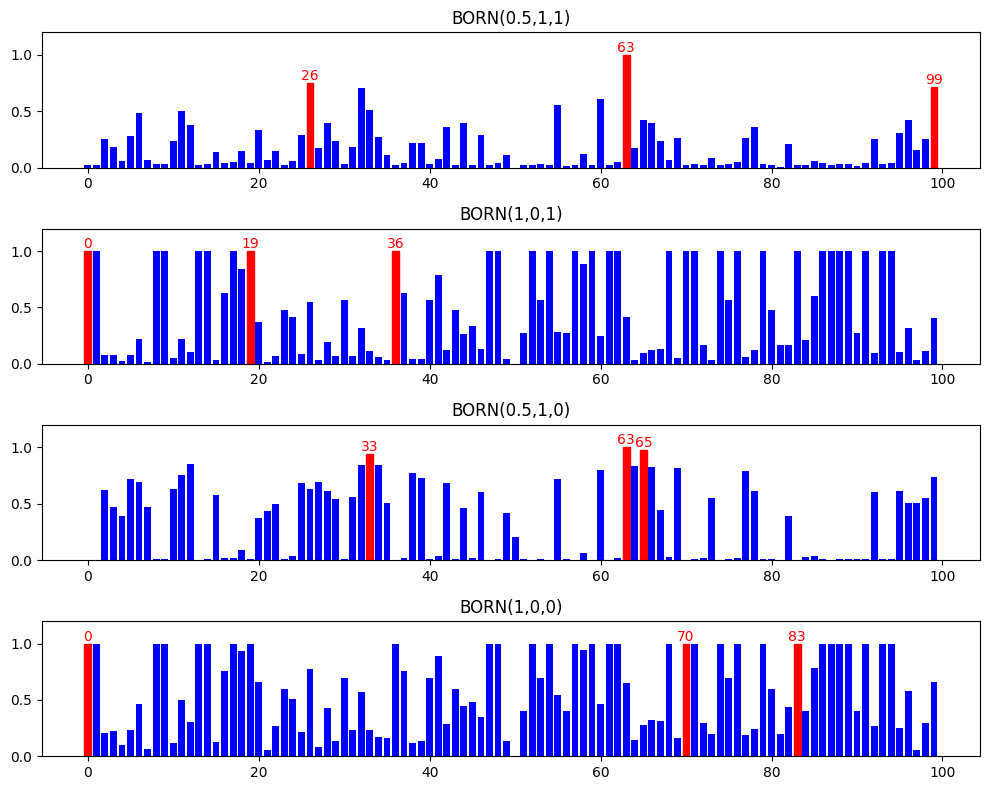

In [ ]:
# array in 0,1
def normalize_array(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

f1_list = [normalize_array(ge511), normalize_array(ge101), normalize_array(ge510), normalize_array(ge100)]
f1_filter= f1_list.copy()

titles = ["BORN(0.5,1,1)", "BORN(1,0,1)", "BORN(0.5,1,0)", "BORN(1,0,0)"]


#  barplot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

for i, (f1_list, title) in enumerate(zip(f1_list, titles)):
    max_values = f1_list
    
    top_indices = np.argsort(max_values)[-3:]  # top 3 features with max element
    top_values = max_values[top_indices]

    bars = axes[i].bar(range(len(max_values)), max_values, color='blue')
    for idx in top_indices:
        bars[idx].set_color('red')  


    for idx in top_indices:
        axes[i].text(idx, max_values[idx], f'{idx}', ha='center', va='bottom', color='red')

    axes[i].set_title(f"{title}")
    axes[i].set_ylim(0, 1.2)

plt.tight_layout()
plt.show()


STEP FILTER

In [ ]:
###step filter
def get_f2_filter(filter, th): 
    return np.array([filter[i] if filter[i] > th else 0 for i in range(len(filter))])


f2_list = [get_f2_filter(array_, 0.5) for array_ in f1_filter]
f2_filter = f2_list.copy()

# f2_arrays = []
# for arr in f1_arrays:
#     prov = f2_filer(arr, 0.5)

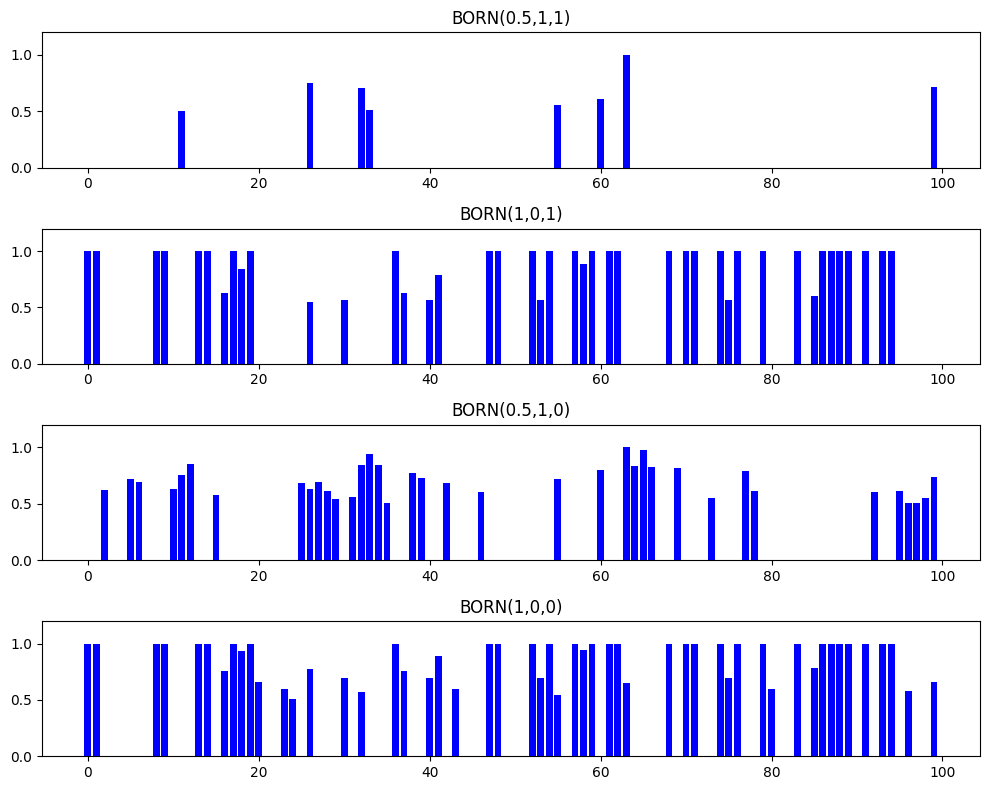

In [ ]:
titles = ["BORN(0.5,1,1)", "BORN(1,0,1)", "BORN(0.5,1,0)", "BORN(1,0,0)"]


# Barplot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

for i, (f2_list, title) in enumerate(zip(f2_list, titles)):
    max_values = f2_list
    
    top_indices = np.argsort(max_values)[-3:]  # top 3 features with max elements
    top_values = max_values[top_indices]

    bars = axes[i].bar(range(len(max_values)), max_values, color='blue')

    axes[i].set_title(f"{title}")
    axes[i].set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

Filter preditction with crosso validation

In [ ]:
from sklearn.model_selection import KFold

def apply_filter(xt,xp, filter, config):
    xt_filter = xt*filter[config]
    xp_filter= xp*filter[config]
    return xt_filter, xp_filter

def evaluate_models(models, xt, yt, xp, yp, cv=5, use_cv=False):
    results = {}

    if use_cv:
        X = np.concatenate((xt, xp), axis=0)
        y = np.concatenate((yt, yp), axis=0).flatten()
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)

        for name, model in models.items():
            f1_scores = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model.fit(X_train, y_train)
                predictions = model.predict(X_val)
                f1 = f1_score(y_val, predictions, average='weighted')
                f1_scores.append(f1)

            mean_f1 = np.mean(f1_scores)
            results[name] = mean_f1
    else:
        for name, model in models.items():
            model.fit(xt, yt)
            predictions = model.predict(xp)
            f1 = f1_score(yp, predictions, average='weighted')
            results[name] = f1

    return results


["BORN(0.5,1,1)", "BORN(1,0,1)", "BORN(0.5,1,0)", "BORN(1,0,0)"]

models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "KNeighbors": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
}

#BORN(0.5,1,1) f1 f2
xt_511_f1, xp_511_f1 = apply_filter(xt, xp, f1_filter, 0)
xt_511_f2, xp_511_f2 = apply_filter(xt, xp, f2_filter, 0)

results_511_f0 = evaluate_models(models, xt, yt, xp, yp)
results_511_f1 = evaluate_models(models, xt_511_f1, yt, xp_511_f1, yp)
results_511_f2 = evaluate_models(models, xt_511_f2, yt, xp_511_f2, yp)

print('511')
#BORN(1,0,1) f1 f2
xt_101_f1, xp_101_f1 = apply_filter(xt,xp,f1_filter, 1)
xt_101_f2, xp_101_f2 = apply_filter(xt,xp,f2_filter, 1)

results_101_f0 = evaluate_models(models, xt, yt, xp, yp)
results_101_f1 = evaluate_models(models, xt_101_f1, yt, xp_101_f1, yp)
results_101_f2 = evaluate_models(models, xt_101_f2, yt, xp_101_f2, yp)
print('101')

#BORN(5,1,0) f1 f2
xt_510_f1, xp_510_f1 = apply_filter(xt,xp,f1_filter, 2)
xt_510_f2, xp_510_f2 = apply_filter(xt,xp,f2_filter, 2)

results_510_f0 = evaluate_models(models, xt, yt, xp, yp)
results_510_f1 = evaluate_models(models, xt_510_f1, yt, xp_510_f1, yp)
results_510_f2 = evaluate_models(models, xt_510_f2, yt, xp_510_f2, yp)

print('510')
#BORN(1,0,0) f1 f2
xt_100_f1, xp_100_f1 = apply_filter(xt,xp,f1_filter, 3)
xt_100_f2, xp_100_f2 = apply_filter(xt,xp,f2_filter, 3)

results_100_f0 = evaluate_models(models, xt, yt, xp, yp)
results_100_f1 = evaluate_models(models, xt_100_f1, yt, xp_100_f1, yp)
results_100_f2 = evaluate_models(models, xt_100_f2, yt, xp_100_f2, yp)

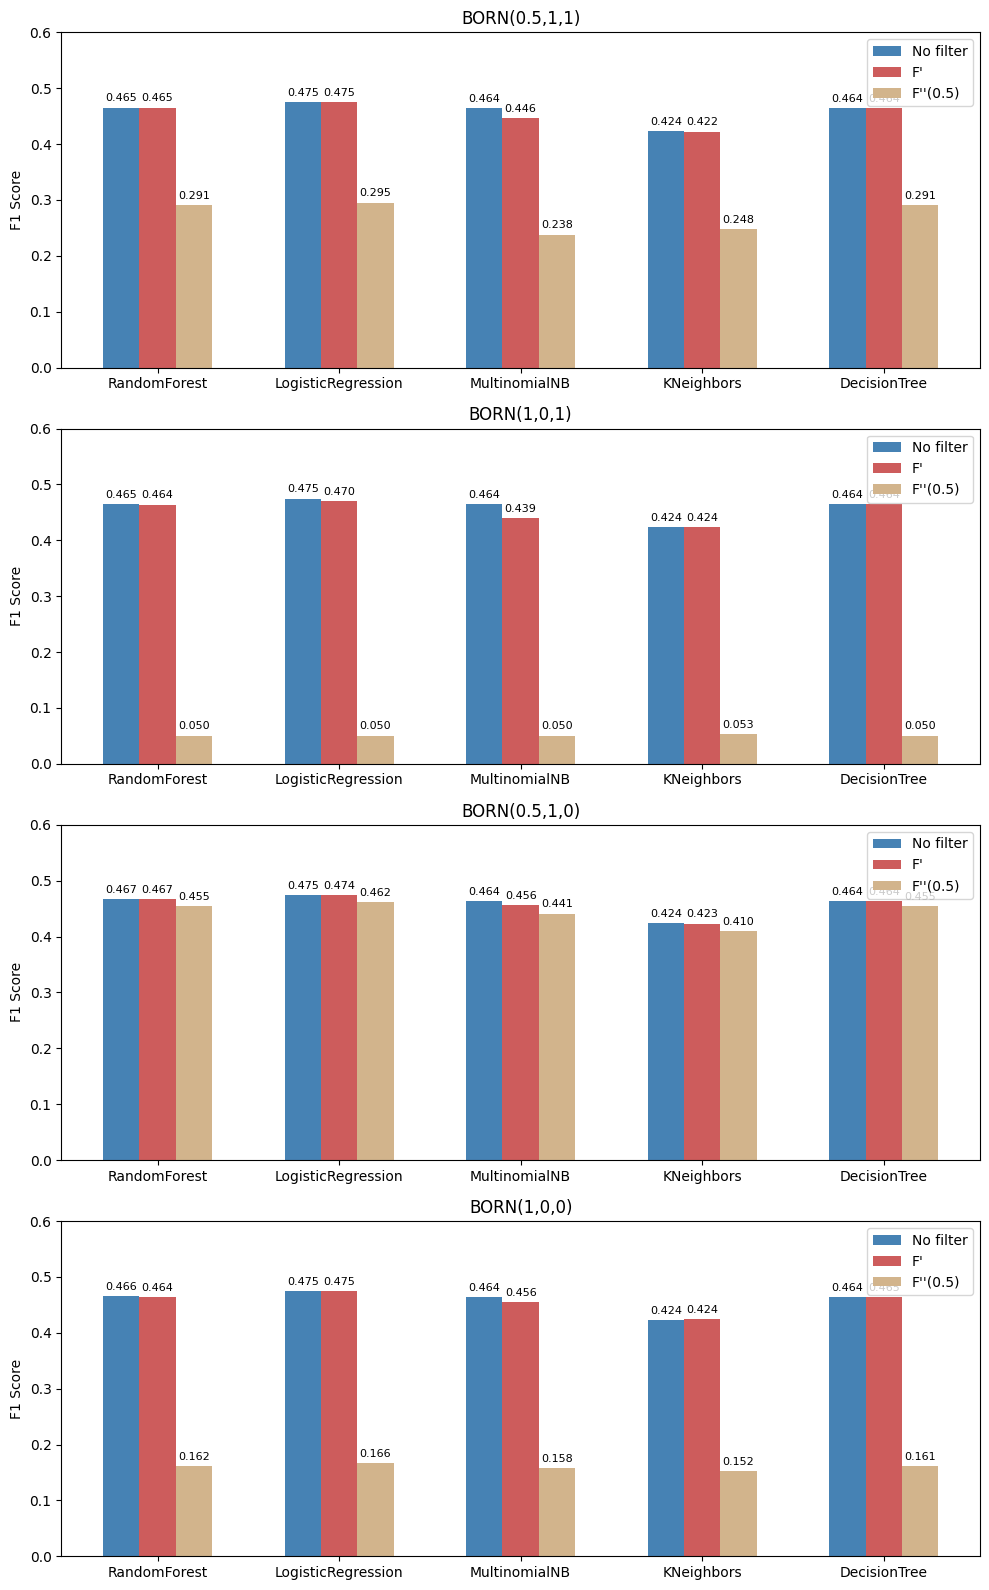

In [ ]:
titles = ["BORN(0.5,1,1)", "BORN(1,0,1)", "BORN(0.5,1,0)", "BORN(1,0,0)"]
results = [
    (results_511_f0, results_511_f1, results_511_f2),
    (results_101_f0, results_101_f1, results_101_f2),
    (results_510_f0, results_510_f1, results_510_f2),
    (results_100_f0, results_100_f1, results_100_f2)
]

colors = {
    'No filter': 'steelblue',
    "F'": 'indianred',
    "F''": 'tan'
}

num_configs = len(titles)

# BARPLOT
fig, axes = plt.subplots(num_configs, 1, figsize=(10, 4 * num_configs))

for idx, (ax, title, (f0, f1, f2)) in enumerate(zip(axes, titles, results)):
    labels = list(f0.keys())
    normal_scores = [f0[model] for model in labels]
    weighted_scores = [f1[model] for model in labels]
    cutoff_scores = [f2[model] for model in labels]

    x = np.arange(len(labels))  
    width = 0.2 
    rects1 = ax.bar(x - width, normal_scores, width, label='No filter', color=colors['No filter'])
    rects2 = ax.bar(x, weighted_scores, width, label="F'", color=colors["F'"])
    rects3 = ax.bar(x + width, cutoff_scores, width, label="F''(0.5)", color=colors["F''"])

    ax.set_ylabel('F1 Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylim(0, 0.60)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 punti di offset verticale
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 8)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

fig.tight_layout()
plt.show()

Let K to vary in F''

In [ ]:
f1_511, f1_101, f1_510, f1_100= [], [], [], []
num_of_vw= []

for i in range(1,10,1): 

    models = {
    "Random Forest": RandomForestClassifier()}

    th = i/10
    #apply threshold
    f2_filter = [get_f2_filter(array_, th) for array_ in f1_filter]

    xt_511_f2, xp_511_f2 = apply_filter(xt, xp, f2_filter, 0)
    xt_101_f2, xp_101_f2 = apply_filter(xt,xp,f2_filter, 1)
    xt_510_f2, xp_510_f2 = apply_filter(xt,xp,f2_filter, 2)
    xt_100_f2, xp_100_f2 = apply_filter(xt,xp,f2_filter, 3)

    f1_511.append(evaluate_models(models, xt_511_f2, yt, xp_511_f2, yp)['Random Forest'])
    f1_510.append(evaluate_models(models, xt_510_f2, yt, xp_510_f2, yp)['Random Forest'])
    f1_101.append(evaluate_models(models, xt_101_f2, yt, xp_101_f2, yp)['Random Forest'])
    f1_100.append(evaluate_models(models, xt_100_f2, yt, xp_100_f2, yp)['Random Forest'])

    num_of_vw.append(sum(sum(f2_filter))/4)

1
2
3
4
5
6
7
8
9


In [ ]:
#PLOT

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x_ticks = [0.1 * i for i in range(1, 10)]  

ax1.plot(x_ticks, f1_511, marker='o', linestyle='-', label='BORN(0.5,1,1)', color="darkred")
ax1.plot(x_ticks, f1_510, marker='o', linestyle='-', label='BORN(0.5,1,0)', color="darkblue")
ax1.plot(x_ticks, f1_101, marker='o', linestyle='-', label='BORN(1,0,1)', color="red")
ax1.plot(x_ticks, f1_100, marker='o', linestyle='-', label='BORN(1,0,0)', color="blue")
ax1.set_title('F1 Scores')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('F1 Score')
ax1.legend()
ax1.grid(True)
ax1.set_xticks(x_ticks)

ax2.plot(x_ticks, num_of_vw, marker='o', linestyle='-', color='b')
ax2.set_title('Average number of Words')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Number of Words')
ax2.grid(True)
ax2.set_xticks(x_ticks)

plt.tight_layout()
plt.show()

